# Rare variant effects

This analysis aimed to answer the following research question: **Which of the variants with rare frequencies in African populations are most likely to contribute to disease, based on predicted effect on protein structure and function?**

To achieve this, the following steps were performed:

1. Genetic Variant Effect Data Retrieval and Preparation: Genetic variant effect scores and predictions were retrieved from [PredictSNP2](https://loschmidt.chemi.muni.cz/predictsnp2/). The retrieved data underwent processing and preparation following guidelines outlined in the `Notebooks\Data_preparation\6-Variant_effect_scores_and_predictions.ipynb` Jupyter notebook. The processed data can be found in the `Data\Processed\Variant_effects.csv` file.
2. Consequence Data Retrieval and Preparation: Genetic variant consequence data was obtained from the Ensembl [Variant Effect Predictor API](https://rest.ensembl.org/). This data underwent processing and preparation for analysis according to procedures outlined in the `Notebooks\Data_preparation\5-Variant_consequences.ipynb `Jupyter notebook. The processed data is stored in the `Data\Processed\Variant_consequences.csv` file. More information on the different consequence classifications can also be found in the `Notebooks\Data_preparation\5-Variant_consequences.ipynb `Jupyter notebook.
2. Analysis and Visualisation:
    * Effect data on rare variants within African subpopulation (ethnolinguistic) groups was selected for analysis.
    * The distribution of variants classified as deleterious or neutral within the studied genes was visualised using a stacked barplot. 
    * Variants were organised based on their level of potential harm, with those predicted to be the most deleterious by various algorithms placed at the top of the table.

## Imports

Notebook setup

In [16]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

Import variant effect data

In [17]:
vep_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_effects.csv",
    )
)

vep_data.head(5)

,Unnamed: 0,CHROM,POS,REF,ALT,SGNF,PSNPE,PSNPS,PSNPC,CADDE,...,FATS,FATC,FUNE,FUNS,FUNC,GWAVAE,GWAVAS,GWAVAC,ID,GENE
0,0,13,110148891,C,G,NaN,neutral,-1.000000,0.88,neutral,...,0.18997,0.77,NaN,NaN,NaN,neutral,0.30,0.68,rs552586867,COL4A1
1,1,13,110148917,C,G,NaN,neutral,-0.319012,0.74,deleterious,...,0.18963,0.77,neutral,8.515992e-06,0.80,neutral,0.32,0.71,rs59409892,COL4A1
2,2,13,110148920,G,C,NaN,neutral,-0.320755,0.74,deleterious,...,0.21184,0.75,?,6.227860e-01,0.49,neutral,0.32,0.71,rs535182970,COL4A1
3,3,13,110148959,A,G,Likely benign,deleterious,0.456207,0.91,deleterious,...,0.82375,0.82,neutral,7.524398e-20,0.80,neutral,0.44,0.53,rs56406633,COL4A1
4,4,13,110148971,G,C,NaN,neutral,-0.155078,0.73,neutral,...,0.95264,0.91,deleterious,1.193686e+00,0.74,neutral,0.44,0.53,rs568536001,COL4A1


Import genetic variant data for African populations

In [18]:
ih_afr = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

ih_afr.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,REG,CORR_IH_AF,VARIANT_TYPE
0,rs552586867,110148891,C,G,COL4A1,NaN,2,350,110148891_G_C,1608.0,1606.0,Recent African,0.001244,SNP
1,rs552586867,110148891,C,G,COL4A1,Yoruba,2,350,110148891_G_C,392.0,390.0,NaN,0.005102,SNP
2,rs59409892,110148917,C,G,COL4A1,Yoruba,40,392,110148917_G_C,392.0,352.0,NaN,0.102041,SNP
3,rs59409892,110148917,C,G,COL4A1,Mende,18,196,110148917_G_C,196.0,178.0,WA,0.091837,SNP
4,rs59409892,110148917,C,G,COL4A1,Bantu South Africa,2,16,110148917_G_C,16.0,14.0,SA,0.125000,SNP


Import variant consequence data

In [19]:
consequence_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_consequences.csv",
    )
)

consequence_data.head(5)

,VAR_NAME,POS,REF,ALT,CONSEQUENCE,GENE,CONSEQUENCE_CLASSIFICATION
0,chr13:110148882C-CT,110148882,C,CT,downstream_gene_variant,COL4A1,upstream/downstream
1,rs552586867,110148891,C,G,downstream_gene_variant,COL4A1,upstream/downstream
2,rs59409892,110148917,C,G,downstream_gene_variant,COL4A1,upstream/downstream
3,rs535182970,110148920,G,C,downstream_gene_variant,COL4A1,upstream/downstream
4,rs56406633,110148959,A,G,downstream_gene_variant,COL4A1,upstream/downstream


## Analysis and Visualisation

### Data selection

Select effect data on rare variants within African subpopulation (ethnolinguistic) groups for analysis. 

In [20]:
# Select aggregated variant count and frequency data for the Recent African population. Remove variants with an alternate allele count of 0. These variants are not present in Recent Africans.

ih_afr_subpops = ih_afr[~(ih_afr["REG"] == "Recent African")]

# Filter for variants with a rare alternate allele frequency (< 0.005)

ih_afr_subpops_rare = ih_afr_subpops[ih_afr_subpops["CORR_IH_AF"] < 0.005]

# Add in effect data for rare variants that are in the Recent African populations
ih_afr_subpops_vep_data = (
    ih_afr_subpops_rare.merge(
        vep_data,
        how="left",
        left_on=["REF", "ALT", "POS", "GENE"],
        right_on=["REF", "ALT", "POS", "GENE"],
    )
    .drop(columns="ID_y")
    .rename(columns={"ID_x": "ID"})
)

ih_afr_subpops_vep_data.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,...,DANNC,FATE,FATS,FATC,FUNE,FUNS,FUNC,GWAVAE,GWAVAS,GWAVAC
0,rs546124548,110149176,T,A,COL4A1,Esan,1,296,110149176_A_T,296.0,...,0.75,?,0.27014,0.48,deleterious,1.378901,0.64,deleterious,0.55,0.80
1,chr13:110150031G-A,110150031,G,A,COL4A1,Esan,1,296,110150031_A_G,296.0,...,0.86,?,0.29479,0.48,?,0.675516,0.44,deleterious,0.47,0.64
2,rs560166628,110150188,C,T,COL4A1,Esan,1,296,110150188_T_C,296.0,...,0.54,deleterious,0.97405,0.95,deleterious,1.193686,0.74,deleterious,0.55,0.80
3,rs184801410,110150251,G,A,COL4A1,Yoruba,1,350,110150251_A_G,392.0,...,0.62,deleterious,0.96808,0.92,deleterious,0.943754,0.68,deleterious,0.62,0.82
4,rs370713090,110150491,C,T,COL4A1,Esan,1,296,110150491_T_C,296.0,...,0.82,neutral,0.21072,0.75,?,0.820832,0.45,neutral,0.31,0.70


How many unique rare variants were identified in the African populations?

In [21]:
ih_afr_subpops_vep_data["ID"].nunique()

1952

How many of the unique, rare variants in each gene were classified as deleterious (potentially harmful)?

In [22]:
# Group dataframe information by gene and effect prediction value

pathogenicity_grouped = (
    ih_afr_subpops_vep_data.drop_duplicates(subset=["ID"])
    .groupby(["GENE", "PSNPE"])
    .count()
    .reset_index()
    .rename(columns={"ID": "COUNT"})[["GENE", "PSNPE", "COUNT"]]
)

# Pivot dataframe

pathogenicity_pivot = pd.pivot(
    pathogenicity_grouped, index=["GENE"], columns=["PSNPE"], values=["COUNT"]
)
pathogenicity_pivot.columns = pathogenicity_pivot.columns.droplevel()
pathogenicity_pivot = pathogenicity_pivot.reset_index().rename(
    columns={
        "deleterious": "DELETERIOUS",
        "neutral": "NEUTRAL",
        "not_classified": "NOT_CLASSIFIED",
    }
)

pathogenicity_pivot

PSNPE,GENE,DELETERIOUS,NEUTRAL
0,AGT,8.0,162.0
1,AP4B1,10.0,30.0
2,CARD8,30.0,263.0
3,CAT,7.0,100.0
4,COL4A1,22.0,589.0
5,IL10,5.0,16.0
6,IL1B,NaN,20.0
7,IL6,5.0,13.0
8,MTHFR,7.0,25.0
9,NOS3,11.0,81.0


How many deleterious rare variants were identified overall?

In [23]:
pathogenicity_pivot["DELETERIOUS"].sum()

109.0

What was the percentage of deleterious rare variants?

In [24]:
pathogenicity_pivot["DELETERIOUS"].sum() / ih_afr_subpops_vep_data["ID"].nunique() * 100

5.584016393442623

Calculate the number of variants that do not have deleterious or neutral classifications.

In [25]:
# Calculate the total number of rare variants per gene

rare_variant_count = (
    ih_afr_subpops_rare[["GENE", "ID"]]
    .drop_duplicates(subset=["ID"])
    .groupby("GENE")
    .count()
    .rename(columns={"ID": "TOTAL"})
)

# Add the total rare variant count to the "pathogenicity_pivot" dataframe

pathogenicity_pivot = (
    pathogenicity_pivot.merge(rare_variant_count, on="GENE")
    .set_index("GENE")
    .reset_index()
)

# Calculate number of variants without classifications. Number of unclassified variants = total variants - (deleterious variant count + neutral variant count)

pathogenicity_pivot["NOT_CLASSIFIED"] = pathogenicity_pivot.TOTAL - (
    pathogenicity_pivot.DELETERIOUS + pathogenicity_pivot.NEUTRAL
)
pathogenicity_pivot = (
    pathogenicity_pivot.drop(columns="TOTAL")
    .set_index("GENE")
    .rename(
        columns={
            "DELETERIOUS": "Deleterious",
            "NEUTRAL": "Neutral",
            "NOT_CLASSIFIED": "Not classified",
        }
    )
)

pathogenicity_pivot.head(5)

,Deleterious,Neutral,Not classified
GENE,,,
AGT,8.0,162.0,32.0
AP4B1,10.0,30.0,2.0
CARD8,30.0,263.0,152.0
CAT,7.0,100.0,28.0
COL4A1,22.0,589.0,226.0


Set plot parameters

In [26]:
sns.set(rc={"figure.figsize": (10, 12)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Generate a stacked barplot visually representing the distribution of variants classified as deleterious or neutral.

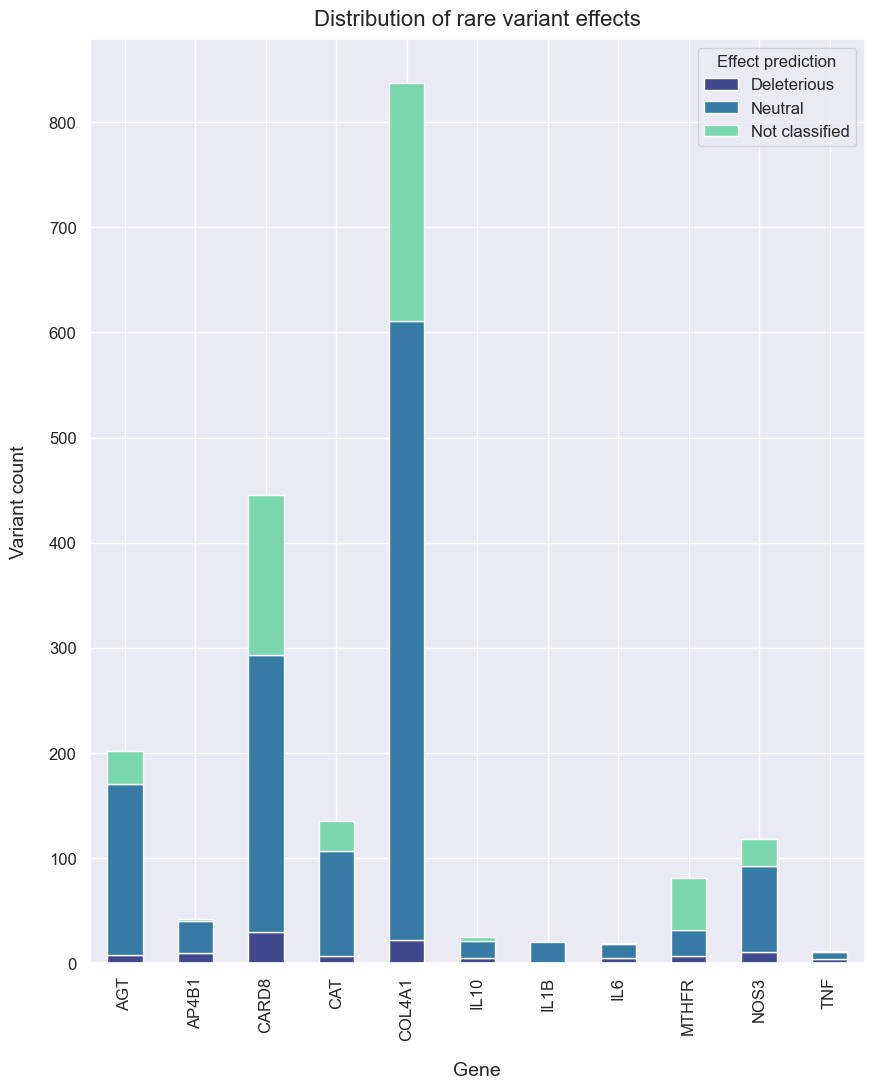

In [27]:
color_dict = dict(
    {"Neutral": "#357BA3", "Deleterious": "#40498E", "Not classified": "#79D6AE"}
)

pathogenicity_plot = functions.create_plot(
    data=pathogenicity_pivot,
    plot_type="stacked_barplot",
    palette=color_dict,
    legend_title="PredictSNP2 consensus prediction",
    legend_loc="upper right",
    x="GENE",
    horizontal_stack=False,
)

plt.xlabel(xlabel="Gene", labelpad=15)
plt.ylabel(ylabel="Variant count", labelpad=15)
plt.legend(title="Effect prediction", loc="upper right")
plt.title("Distribution of rare variant effects", size=constants.LARGEST_FONT, pad=10)

plt.savefig(
    "..\Results\Figures\Rare_variant_effects.png", dpi=1200, bbox_inches="tight"
)
plt.show()

Order rare variants with deleterious predictions based on their level of potential harm, with those predicted to be the most deleterious by various algorithms placed at the top of the table.

In [28]:
# Score rare variants based on number of deleterious effect predictions by various algorithms

vep_scored = ih_afr_subpops_vep_data[
    ih_afr_subpops_vep_data["PSNPE"] == "deleterious"
].copy()
vep_scored["VAR_IMPACT"] = vep_scored.eq("deleterious").sum(axis=1)

# Sort by variant impact

vep_scored = vep_scored.sort_values(by="VAR_IMPACT", ascending=False).reset_index(
    drop=True
)[["VAR_NAME", "POS", "REF", "ALT", "GENE", "SUB_POP", "CORR_IH_AF", "VAR_IMPACT"]]


vep_scored.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,CORR_IH_AF,VAR_IMPACT
0,rs560166628,110150188,C,T,COL4A1,Esan,0.003378,6
1,rs145182838,113898727,T,C,AP4B1,Mandinka,0.002841,6
2,rs537401710,31575514,C,T,TNF,Esan,0.003378,6
3,rs183156478,206770659,C,T,IL10,Yoruba,0.002551,6
4,chr1:206769473C-A,206769473,C,A,IL10,Esan,0.003378,6


Add information on the consequences of rare variants with predicted deleteriousness on a gene/protein.

In [29]:
# Add in consequence data for rare variants with predicted deleterious effects

vep_scored = vep_scored.merge(
    consequence_data,
    how="left",
    left_on=["VAR_NAME", "REF", "ALT", "POS", "GENE"],
    right_on=["VAR_NAME", "REF", "ALT", "POS", "GENE"],
)

vep_scored.head(11)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,CORR_IH_AF,VAR_IMPACT,CONSEQUENCE,CONSEQUENCE_CLASSIFICATION
0,rs560166628,110150188,C,T,COL4A1,Esan,0.003378,6,3_prime_UTR_variant,untranslated region
1,rs145182838,113898727,T,C,AP4B1,Mandinka,0.002841,6,missense_variant,missense
2,rs537401710,31575514,C,T,TNF,Esan,0.003378,6,upstream_gene_variant,upstream/downstream
3,rs183156478,206770659,C,T,IL10,Yoruba,0.002551,6,intron_variant,intronic
4,chr1:206769473C-A,206769473,C,A,IL10,Esan,0.003378,6,intron_variant,intronic
5,rs555751737,151001252,G,A,NOS3,Mandinka,0.002841,6,missense_variant,missense
6,chr11:34449368G-A,34449368,G,A,CAT,Yoruba,0.002551,6,splice_donor_5th_base_variant | intron_variant,splice site
7,rs552501121,150998961,G,A,NOS3,Esan,0.003378,6,missense_variant,missense
8,rs45496998,11792355,G,A,MTHFR,Mandinka,0.002841,6,missense_variant,missense
9,rs541115295,230691565,G,A,AGT,Mandinka,0.002841,6,NaN,NaN


Save results

In [30]:
# Save variant impact results

vep_scored.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Results",
        "Tables",
        "Variant_impact.csv",
    ),
    index=False,
)